In [1]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer as timer
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import helperfunction as hf
import cnn_models as cnn

2025-02-16 20:35:47.876539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739709347.891304    1993 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739709347.895550    1993 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 20:35:47.910365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Set GPU Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1739688569.305547     479 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## ACCESS IMAGES IN THE DIRECTORY

In [ ]:
# Define the directory for images
# Rice Bran
# partial_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Dataset Images\\Rice Bran\\Raw\\Set 2'
# partial_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Raw/Set 2'

# Soybean Meal
# partial_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Dataset Images\\Soybean Meal\\Raw\\Set 1'
partial_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Raw/Set 1'

# Define the subdirectories for each fabric type
pure_dir = os.path.join(partial_dir, 'Pure')
adulterated_dir = os.path.join(partial_dir, 'Adulterated')

# display sample image
#image_path = os.path.join(adulterated_dir, 'adulterated_rb (500).jpg')
#image_path = os.path.join(pure_dir, 'pure_rb (500).jpg')

#image_path = os.path.join(adulterated_dir, 'adulterated_sbm (5).jpg')
image_path = os.path.join(pure_dir, 'pure_sbm (5).jpg')


img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


# PRE-PROCESS IMAGES

In [7]:
# get images in each directory
def process_one_image(directory, output_path, img_index, class_name, kernel_num, limit_num):
    # Get a list of files in the directory, sorted by filename
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('(')[1].split(')')[0]))

    for filename in files:
        if f'{class_name} ({img_index}).jpg' in filename and img_index <= limit_num:
            filepath = os.path.join(directory, filename)
            # print(filepath)
            # print(type(filepath))
            # print(type(filepath))
            
            if os.path.isfile(filepath):
                # Load the image
                img_samp = cv2.imread(filepath)

                if img_samp is not None:
                    # Extract RGB channels
                    r_channel = img_samp[:, :, 2]
                    g_channel = img_samp[:, :, 1]
                    b_channel = img_samp[:, :, 0]

                    # convert to gray image
                    gray_img = np.uint8((0.299 * r_channel)) + np.uint8((0.587 * g_channel)) + np.uint8((0.114 * b_channel))

                    # threshold image
                    thres_img = hf.segment_img(gray_img)

                    # Define a rectangular structuring element (kernel)
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_num, kernel_num))
                    
                    # Clean thresholded image
                    opened_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel)

                    # Make the thresholded image into a 500 x 500 resolution
                    final_img = hf.extract_and_resize_foreground(img_samp, opened_img)

                    # Create the output folder if it doesn't exist
                    os.makedirs(output_path, exist_ok=True)

                    image_name = f'image ({img_index}).jpg'
                    img_index += 1
                    path = os.path.join(output_path, image_name)
                    cv2.imwrite(path, final_img)
                else:
                    print(f"Error: Unable to load {filename}")

# get images in each directory
def process_two_image(directory, output_path, img_index, class_name, limit_num, target_size):
    # Get a list of files in the directory, sorted by filename
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('(')[1].split(')')[0]))

    for filename in files:
        if f'{class_name} ({img_index}).jpg' in filename and img_index <= limit_num:
            filepath = os.path.join(directory, filename)
            # print(filepath)
            # print(type(filepath))
            # print(type(filepath))
            
            if os.path.isfile(filepath):
                # Load the image
                img_samp = cv2.imread(filepath)

                if img_samp is not None:
                    
                    final_img = hf.resize_img(img_samp, target_size)

                    # Create the output folder if it doesn't exist
                    os.makedirs(output_path, exist_ok=True)

                    image_name = f'image ({img_index}).jpg'
                    img_index += 1
                    path = os.path.join(output_path, image_name)
                    cv2.imwrite(path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
                    
                else:
                    print(f"Error: Unable to load {filename}")

### Rice Bran Pre-processing

In [ ]:
# initialize kernel
default_kernel = 5

# Rice Bran Paths
adulterated_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Set 3\Adulterated'
pure_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Set 3\Pure'

# adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Adulterated'
# pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Pure'

# process_one_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_rb', default_kernel, 500)
# process_one_image(pure_dir, pure_output_folder_path, 1, 'pure_rb', default_kernel, 500)

#adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 4/Adulterated'
#pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 4/Pure'

#process_two_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_rb', 500, 2800)
#process_two_image(pure_dir, pure_output_folder_path, 1, 'pure_rb', 500, 2800)

### Soybean Meal Pre-processing

In [11]:
# initialize kernel
default_kernel = 5

# Soybean Meal Paths
# adulterated_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Set 3\Adulterated'
# pure_output_folder_path = rf'C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Processed\Set 3\Pure'

adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 1/Adulterated'
pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 1/Pure'

process_one_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_sbm', default_kernel, 500)
process_one_image(pure_dir, pure_output_folder_path, 1, 'pure_sbm', default_kernel, 500)

adulterated_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 2/Adulterated'
pure_output_folder_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 2/Pure'

process_two_image(adulterated_dir, adulterated_output_folder_path, 1, 'adulterated_sbm', 500, 2800)
process_two_image(pure_dir, pure_output_folder_path, 1, 'pure_sbm', 500, 2800)

### For depicted image

In [15]:
# Saving image that don't need high kernel
# Adulterated
changed_kernel_1 = 3
process_one_image(adulterated_dir, adulterated_output_folder_path, 241, 'adulterated_rb', changed_kernel_1, 260)


# Pure
# changed_kernel_2 = 5
# process_image(pure_dir, pure_output_folder_path, 301, 'pure_rb', changed_kernel_2, 420)

### Transfer Images for Training and Testing

In [ ]:
# Rice Bran
aduterated_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Adulterated'
pure_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 2/Pure'

aduterated_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 4/Adulterated'
pure_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Processed/Set 4/Pure'

# hf.transfer_image_train_and_test(aduterated_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 2/Adulterated')

# hf.transfer_image_train_and_test(pure_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 2/Pure')

# hf.transfer_image_train_and_test(aduterated_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 4/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 4/Adulterated')

# hf.transfer_image_train_and_test(pure_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 4/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 4/Pure')

In [ ]:
# Soybean Meal
adulterated_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 1/Adulterated'
pure_sourcepath_1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 1/Pure'

adulterated_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 2/Adulterated'
pure_sourcepath_2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Processed/Set 2/Pure'

# hf.transfer_image_train_and_test(adulterated_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 1/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1/Adulterated')

hf.transfer_image_train_and_test(pure_sourcepath_1, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 1/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1/Pure')

# hf.transfer_image_train_and_test(adulterated_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 2/Adulterated', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 2/Adulterated')

# hf.transfer_image_train_and_test(pure_sourcepath_2, '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 2/Pure', '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 2/Pure')

### Data Augmentation

In [10]:
# Rice Bran
#dir1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 4'
#dir2 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3'

# Soybean Meal
dir1 = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1'

# Define the subdirectories for each type
pure_dir1 = os.path.join(dir1, 'Pure')
adulterated_dir1 = os.path.join(dir1, 'Adulterated')

# pure_dir2 = os.path.join(dir2, 'Pure')
# adulterated_dir2 = os.path.join(dir2, 'Adulterated')

hf.img_augmentation(pure_dir1, 2000)
hf.img_augmentation(adulterated_dir1, 2000)

# hf.img_augmentation(pure_dir2)
# hf.img_augmentation(adulterated_dir2)

Initialised with 200 image(s) found.
Output directory set to /mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1/Pure/output.

Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x7F125BE03050>: 100%|██████████| 2000/2000 [00:29<00:00, 67.52 Samples/s]                  


Initialised with 200 image(s) found.
Output directory set to /mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1/Adulterated/output.

Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x7F1258DE0B60>: 100%|██████████| 2000/2000 [00:32<00:00, 62.39 Samples/s]                  


### Experiment Part

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
#img_samp = cv2.imread(rf"C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Dataset Images\Rice Bran\Raw\Pure\pure_rb (21).jpg", cv2.COLOR_BGR2RGB)
#img_samp = cv2.imread(rf"C:\Users\hp\Documents\VSU Files\Fourth Year\Thesis\Program\Dataset Images\Rice Bran\Raw\Adulterated\adulterated_rb (125).jpg", cv2.COLOR_BGR2RGB)

#img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Raw/Set 2/Adulterated/adulterated_rb (1)'
img_samp = cv2.imread(image_path)

thres_img = hf.segment_img(img_samp)

# img_rgb = cv2.cvtColor(thres_img, cv2.COLOR_BGR2RGB)

axes[0].imshow(thres_img)
axes[0].set_title("Image")
axes[0].axis('off')

#Extract RGB channels
r_channel = img_samp[:, :, 2]
g_channel = img_samp[:, :, 1]
b_channel = img_samp[:, :, 0]

gray_img = np.uint8((0.299 * r_channel)) + np.uint8((0.587 * g_channel)) + np.uint8((0.114 * b_channel))

# Display the image in the first subplot
axes[0].imshow(img_samp) 
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the grayscale image in the second subplot (if needed)
axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis('off')

# Display the thresholded image in the second subplot (if needed)
thres_img = hf.segment_img(gray_img)
axes[2].imshow(thres_img, cmap='gray')
axes[2].set_title("Thresholded Image")
axes[2].axis('off')


# Define a rectangular structuring element (kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opened_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel)

final_img = hf.extract_and_resize_foreground(img_samp, opened_img)

axes[3].imshow(final_img)
axes[3].axis('off')
axes[3].set_title("Clean Image")




In [ ]:
# Convert BGR to RGB for Matplotlib display
# img_rgb = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)

# print(img_rgb.shape)

# target_size = 2800
# pos = 2

# # Draw triangle in the image
# cv2.rectangle(img_rgb, ((img_rgb.shape[1] - target_size) // pos, (img_rgb.shape[0] - target_size) // pos), ((img_rgb.shape[1] + target_size) // pos, (img_rgb.shape[0] + target_size) // pos), (0, 255, 0), 3)

# # Display the image with aspect ratio preserved and no axes
# plt.imshow(img_rgb)
# plt.axis('off')
# plt.show()

img_samp = cv2.imread(image_path)
# Convert BGR to RGB for Matplotlib display
img_rgb = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)

print(img_rgb.shape)

target_size = 2800
pos = 2

# Define the rectangle coordinates
x1 = (img_rgb.shape[1] - target_size) // pos
y1 = (img_rgb.shape[0] - target_size) // pos
x2 = (img_rgb.shape[1] + target_size) // pos
y2 = (img_rgb.shape[0] + target_size) // pos

# Draw rectangle in the image
cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Extract the region of interest (ROI) within the rectangle
roi = img_rgb[y1:y2, x1:x2]

# Resize the ROI to 400x400
resized_roi = cv2.resize(roi, (400, 400))

# Save the resized ROI
#cv2.imwrite('resized_roi2.jpg', cv2.cvtColor(resized_roi, cv2.COLOR_RGB2BGR))

# Display the original image with the rectangle
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Display the resized ROI
plt.imshow(resized_roi)
plt.axis('off')
plt.show()

print(resized_roi.shape)


## START OF THE TRAINING PROCESS

In [11]:
# Define the base directory
# Rice Bran
#base_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Program\\Dataset Images\\Raw\\Rice Bran\\Training and Validation'
#base_dir = 'C:\\Users\\hp\\Documents\\VSU Files\\Fourth Year\\Thesis\\Program\\Dataset Images\\Rice Bran\\Raw'
#base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3'

# Soybean Meal
# base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 2'
base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1'

# Define the subdirectories for each type
pure_rb_dir = os.path.join(base_dir, 'Pure')
adulterated_rb_dir = os.path.join(base_dir, 'Adulterated')

# image_path = os.path.join(adulterated_rb_dir, 'Adulterated_original_image (13).jpg_4a486883-be2c-414c-9d5e-0545d28807d8.jpg')
# img = mpimg.imread(image_path)
# print(img.shape)
# plt.imshow(img)
# plt.show()


### Data Splitting

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='training',
    seed = 123,
    label_mode='binary',
    image_size=(400, 400),
    batch_size=32,
    shuffle=True
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='validation',
    seed = 123,
    label_mode='binary',
    image_size=(400, 400),
    batch_size=32,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
['Adulterated', 'Pure']


### Training Process With Different Types of CNN Architecture

#### Custom CNN Model

In [ ]:
# number of epochs
epoch = 10
start = timer()

# Custom CNN Model
custom_model = cnn.CustomModel()
custom_model.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

custom_model_history = custom_model.fit(x = train_ds, validation_data=validation_ds, epochs=epoch)
print('Total Time consumed for ' + str(epoch) + ' --->', timer()-start)

#### Evaluate Model

In [ ]:
fig_one = plt.gcf()

# Model Accuracy
plt.plot(custom_model_history.history['accuracy'])
plt.plot(custom_model_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
# Model Loss
plt.plot(custom_model_history.history['loss'])
plt.plot(custom_model_history.history['val_loss'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#### ResNet-50 Model

In [13]:
# number of epochs
epoch = 15
start = timer()

# ResNet50 Model
resnet_model = cnn.ResNetModel()
resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.fit(x = train_ds, validation_data=validation_ds, epochs=epoch)

# Fine-tuning (Unfreeze Top Layers)
pretrained_model = resnet_model.layers[0] # Get the ResNet50 model

# Unfreeze some top layers (experiment with the number)
for layer in pretrained_model.layers[165:]:  # Unfreeze from layer 100 onwards (adjust)
    layer.trainable = True

# Important: Recompile the model after changing trainable status
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),  # Very low learning rate for fine-tuning
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

resnet50_model_history = resnet_model.fit(x = train_ds, validation_data=validation_ds, epochs=5)
print('Total Time consumed for ' + str(epoch) + ' epoch/s --->', timer()-start)

Total number of layers in ResNet50: 176


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,654,625 (90.24 MB)

 Trainable params: 66,785 (260.88 KB)

 Non-trainable params: 23,587,840 (89.98 MB)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.5161 - loss: 0.9565 - val_accuracy: 0.2362 - val_loss: 0.9342
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.5539 - loss: 0.9256 - val_accuracy: 0.2237 - val_loss: 1.0188
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.5686 - loss: 0.8783 - val_accuracy: 0.3375 - val_loss: 0.9714
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.5746 - loss: 0.8774 - val_accuracy: 0.3887 - val_loss: 0.9376
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.6003 - loss: 0.8349 - val_accuracy: 0.4737 - val_loss: 0.8799
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.6355 - loss: 0.7596 - val_accuracy: 0.4650 - val_loss: 0.8686
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.6175 - loss: 0.7941 - val_accuracy: 0.4938 - val_loss: 0.8315
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.6461 - loss: 0

#### Evaluate Model

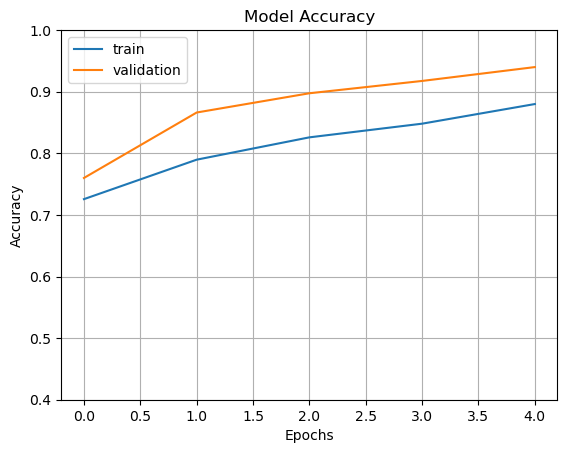

In [14]:
fig_one = plt.gcf()

# Model Accuracy
plt.plot(resnet50_model_history.history['accuracy'])
plt.plot(resnet50_model_history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax = 1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

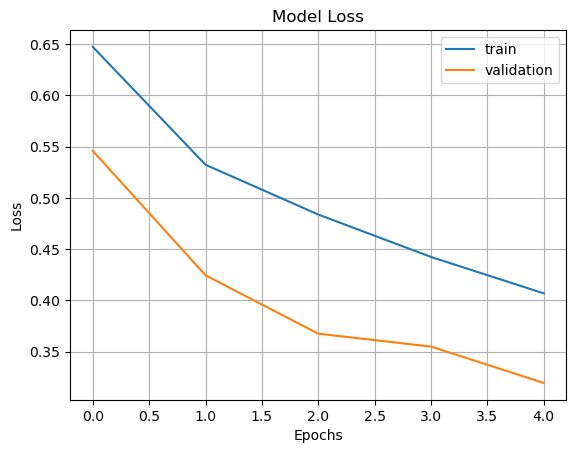

In [15]:
# Model Loss
plt.plot(resnet50_model_history.history['loss'])
plt.plot(resnet50_model_history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## TESTING THE MODEL

In [19]:
# Testing Dataset Directory
# Rice Bran
# test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3'

# Soybean Meal
test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 2'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(400, 400),
    batch_size=32,
    label_mode='binary',
    shuffle=False
)

Found 600 files belonging to 2 classes.


### Evaluate Custom Model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = custom_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = custom_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # For binary classification

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Evaluate ResNet Model

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.8624 - loss: 0.3524
Test Loss: 0.7309847474098206
Test Accuracy: 0.6150000095367432


2025-02-16 21:35:57.535505: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.56      1.00      0.72       300
        Pure       1.00      0.23      0.37       300

    accuracy                           0.61       600
   macro avg       0.78      0.61      0.55       600
weighted avg       0.78      0.61      0.55       600

Precision: 1.0
Recall: 0.23
F1 Score: 0.37398373983739835


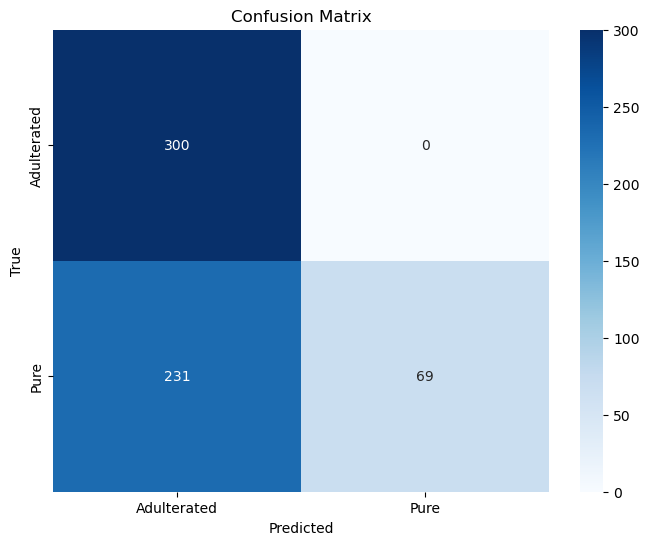

In [20]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = resnet_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # For binary classification

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save the Model

In [18]:
# Save the entire model
# Rice Bran
#resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_resnet_11.h5')
#custom_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_custom_7.h5')

# Soybean Meal
resnet_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Soybean Meal/set1_sbm_resnet_2.h5')

## TEST THE SAVED MODELS

In [ ]:
# test sample image

# Step 1: Load the saved model
loaded_model = load_model('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_resnet_9.h5')
#loaded_model = load_model('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/rb_custom_6.h5')

# Step 2: Verify the loaded model
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f'Test Loss (Loaded Model): {test_loss}')
print(f'Test Accuracy (Loaded Model): {test_accuracy}')

# Generate predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = loaded_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # For binary classification

# Compute evaluation metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.9565 - loss: 0.2148
Test Loss (Loaded Model): 0.21950340270996094
Test Accuracy (Loaded Model): 0.9483333230018616
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Adulterated


### Demo Individual Images

In [ ]:
# Step 3: Make predictions on new data
#img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3/Pure/image (1).jpg'
img_path = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3/Adulterated/image (1).jpg'
img = image.load_img(img_path, target_size=(400, 400))  # Resize to match model input size
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#img_array = img_array / 255.0  # Normalize pixel values (if required)

# Make a prediction
prediction = loaded_model.predict(img_array)

# For binary classification, convert probabilities to class labels
if prediction > 0.5:
    print("Predicted Class: Pure")
else:
    print("Predicted Class: Adulterated")